In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import altair as alt
import arviz as az
import pymc_extras as pmx
import pytensor.tensor as pt

t_dict = {}

In [2]:
# Overall team stats
stats = pd.read_csv('./data/basketball_results/team_statistics.csv').rename(columns={'Unnamed: 0': 'team'})
stats

,team,wins,losses,points_scored,points_conceded,matches_played,win_percentage,avg_points_scored,avg_points_conceded,point_difference
0,VEF Riga,28,4,2712,2262,32,87.5,84.8,70.7,450
1,BC Kalev/Cramo,27,5,2816,2413,32,84.4,88.0,75.4,403
2,Rigas Zelli,25,8,2772,2370,33,75.8,84.0,71.8,402
3,BK Ogre,19,12,2517,2394,31,61.3,81.2,77.2,123
4,Tartu Ulikool,18,13,2524,2518,31,58.1,81.4,81.2,6
5,Valmiera Glass Via,17,13,2470,2319,30,56.7,82.3,77.3,151
6,BK Liepaja,15,15,2502,2458,30,50.0,83.4,81.9,44
7,Rapla,14,14,2312,2288,28,50.0,82.6,81.7,24
8,Tal Tech,14,14,2259,2326,28,50.0,80.7,83.1,-67
9,Ventspils,15,16,2735,2637,31,48.4,88.2,85.1,98


In [3]:
# Granular Match results
results = pd.read_csv('./data/basketball_results/all_matches.csv')
results.date_time = pd.to_datetime(results.date_time)
results['diff'] = results.home_score - results.away_score
results.head()

,match_id,date_time,home_team,away_team,home_score,away_score,margin,winner,home_q1,away_q1,...,away_q2,home_q3,away_q3,home_q4,away_q4,round,home_q5,away_q5,total_points,diff
0,g_3_fBT5X2OG,2025-04-05,Rigas Zelli,BC Kalev/Cramo,97,83,14,Rigas Zelli,18,17,...,22,29,15,26,29,Semi-finals,NaN,NaN,180,14
1,g_3_fNok1m14,2025-04-03,VEF Riga,BK Ogre,80,63,17,VEF Riga,24,13,...,27,14,14,22,9,Semi-finals,NaN,NaN,143,17
2,g_3_6DDQJ5Q6,2025-04-02,BC Kalev/Cramo,Rigas Zelli,87,80,7,BC Kalev/Cramo,19,16,...,22,28,23,21,19,Semi-finals,NaN,NaN,167,7
3,g_3_hhdogXiU,2025-03-30,VEF Riga,Ventspils,87,74,13,VEF Riga,23,17,...,26,22,16,18,15,Quarter-finals,NaN,NaN,161,13
4,g_3_b5iwV433,2025-03-29,Rigas Zelli,Tartu Ulikool,78,73,5,Rigas Zelli,21,19,...,19,12,14,23,21,Quarter-finals,NaN,NaN,151,5


In [4]:
# Plot home/away score differences over time

base = alt.Chart().mark_circle().encode(
    x=alt.X('yearmonth(date_time):T').title(None).axis(grid=False, labelAngle=270, tickCount=2, format='%m-%y'),
    y=alt.Y('diff:Q').title('score difference').axis(grid=False).scale(domainMid=0), 
    color=alt.when(alt.datum.diff>0).then(alt.value("steelblue")).otherwise(alt.value("red")),
    tooltip=[alt.Tooltip('home_team:N', title='home team:'), alt.Tooltip('away_team:N', title='away team:'), alt.Tooltip('diff:Q', title='score diff:')]
    #facet=alt.Facet('home_team:N', columns=4).title(None)
).properties(height=80, width=80)

line = alt.Chart(pd.DataFrame({'y': [1]})).mark_rule(size=0.5, strokeDash=[2,2]).encode(y='y')

home = alt.layer(base, line, data=results).facet('home_team:N', columns=5)

base = alt.Chart().mark_circle().transform_calculate(
    a_diff='0-datum.diff'
).encode(
    x=alt.X('yearmonth(date_time):T').title(None).axis(grid=False, labelAngle=270, tickCount=2, format='%m-%y'),
    y=alt.Y('a_diff:Q').title('score difference').axis(grid=False).title(None).scale(domainMid=0), 
    color=alt.when(alt.datum.a_diff>0).then(alt.value("steelblue")).otherwise(alt.value("red")),
    tooltip=[alt.Tooltip('home_team:N', title='home team:'), alt.Tooltip('away_team:N', title='away team:'), alt.Tooltip('diff:Q', title='score diff:')]
    #facet=alt.Facet('home_team:N', columns=4).title(None)
).properties(height=80, width=80)

line = alt.Chart(pd.DataFrame({'y': [1]})).mark_rule(size=0.5, strokeDash=[2,2]).encode(y='y')

away = alt.layer(base, line, data=results).facet('away_team:N', columns=5)

(home | away).configure(font='SF Compact Rounded')

alt.HConcatChart(...)

In [5]:
# Get list of teams
teams = list(set(results["home_team"]).union(set(results["away_team"])))
n_teams = len(teams)

# Encode teams as indices
team_idx = {team: i for i, team in enumerate(teams)}
results["home_idx"] = results["home_team"].map(team_idx)
results["away_idx"] = results["away_team"].map(team_idx)

# Add binary outcome variable
results['home_win'] = results['home_score'] > results['away_score']

results[['home_team','home_idx','home_score','away_team','away_idx','away_score','diff','home_win']].head()

,home_team,home_idx,home_score,away_team,away_idx,away_score,diff,home_win
0,Rigas Zelli,12,97,BC Kalev/Cramo,7,83,14,True
1,VEF Riga,0,80,BK Ogre,1,63,17,True
2,BC Kalev/Cramo,7,87,Rigas Zelli,12,80,7,True
3,VEF Riga,0,87,Ventspils,2,74,13,True
4,Rigas Zelli,12,78,Tartu Ulikool,5,73,5,True


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [team_strengths]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


Output()

Sampling: [score_diff_obs]


Output()

                                        mean     sd  hdi_3%  hdi_97%  \
team_strengths[VEF Riga]               2.406  0.550   1.374    3.404   
team_strengths[BK Ogre]                0.745  0.418  -0.035    1.520   
team_strengths[Ventspils]              0.165  0.428  -0.623    0.996   
team_strengths[Keila Coolbet]         -1.203  0.477  -2.086   -0.309   
team_strengths[Parnu]                 -0.559  0.452  -1.384    0.292   
team_strengths[Tartu Ulikool]          0.653  0.421  -0.089    1.482   
team_strengths[Tal Tech]               0.038  0.416  -0.737    0.822   
team_strengths[BC Kalev/Cramo]         2.240  0.526   1.255    3.236   
team_strengths[Rapla]                  0.033  0.434  -0.785    0.822   
team_strengths[Viimsi]                -1.972  0.556  -2.984   -0.934   
team_strengths[BK Liepaja]             0.186  0.426  -0.603    0.985   
team_strengths[Keila KK]              -2.277  0.584  -3.410   -1.218   
team_strengths[Rigas Zelli]            1.706  0.458   0.811    2

array([[<Axes: title={'center': 'team_strengths'}>,
        <Axes: title={'center': 'team_strengths'}>]], dtype=object)

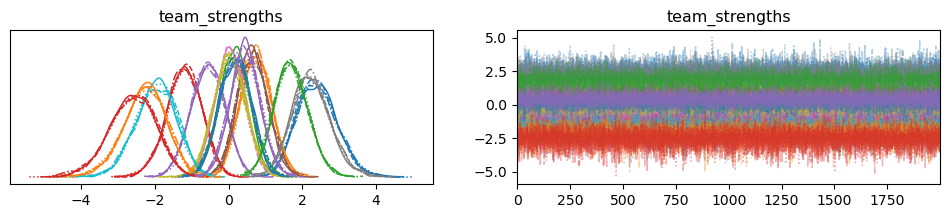

In [6]:
# Win/loss model with team strenghts (ELO)
with pm.Model(coords={"teams": teams}) as model:
    # Latent strength for each team
    team_strengths = pm.ZeroSumNormal("team_strengths", sigma=3, dims="teams")
    
    # Expected log-odds of home win
    mu = (team_strengths[results["home_idx"].values] 
          - team_strengths[results["away_idx"].values])
    
    # Observed win/loss
    pm.Bernoulli("score_diff_obs", p=pm.math.sigmoid(mu), observed=results["home_win"])
    
    # Sampling
    trace = pm.sample(accept=0.9, draws=2000) #, nuts_sampler='nutpie')
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

print(pm.summary(trace))
pm.plot_trace(trace)


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

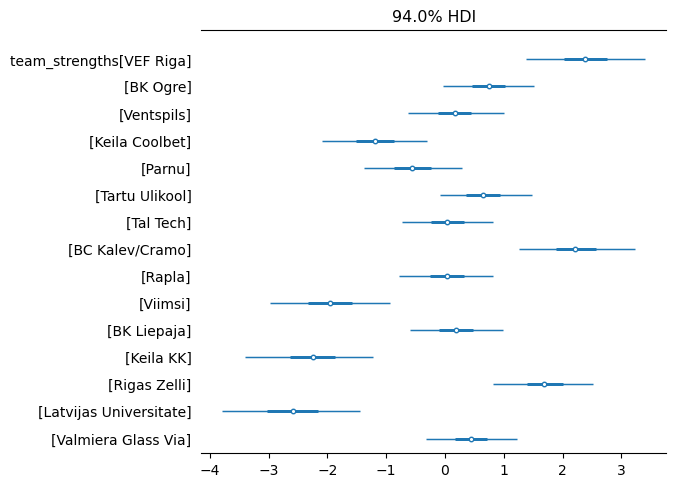

In [7]:
# Posterior analysis
az.plot_forest(trace, var_names=["team_strengths"], combined=True, textsize=10)

### 👇 Improve!

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [team_strengths, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


Output()

Sampling: [score_diff_obs]


Output()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

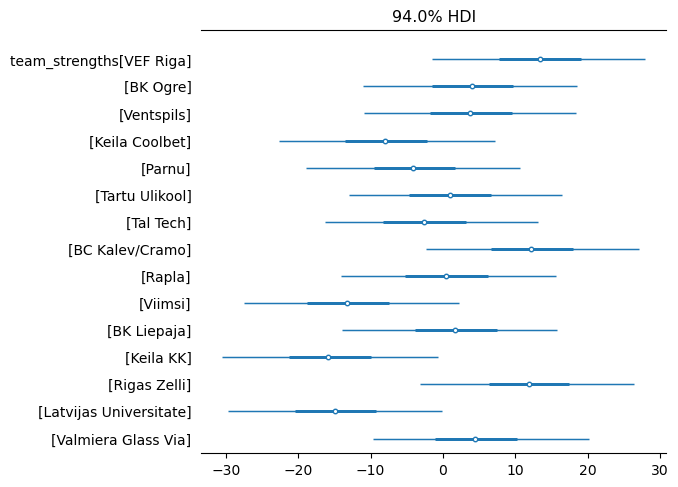

In [8]:
# Baseline score difference model with Normal likelihood

with pm.Model(coords={"teams": teams}) as model:
    # Latent strength for each team
    team_strengths = pm.Normal("team_strengths", mu=0, sigma=30, dims="teams")
    
    # Expected score difference
    mu = (team_strengths[results["home_idx"].values] 
          - team_strengths[results["away_idx"].values])
    
    # Normal likelihood
    sigma = pm.HalfNormal("sigma", sigma=30)
    score_diff_obs = pm.Normal("score_diff_obs", 
                                mu=mu, sigma=sigma, 
                                observed=results["diff"].values)
                
    # Sampling
    trace = pm.sample(accept=0.9, draws=2000) #, nuts_sampler='nutpie')
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

t_dict['normal_model'] = trace # Save the model trace for model comparison

az.plot_forest(trace, var_names=["team_strengths"], combined=True, textsize=10)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [team_strengths, alpha, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


Output()

Sampling: [score_diff_obs]


Output()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

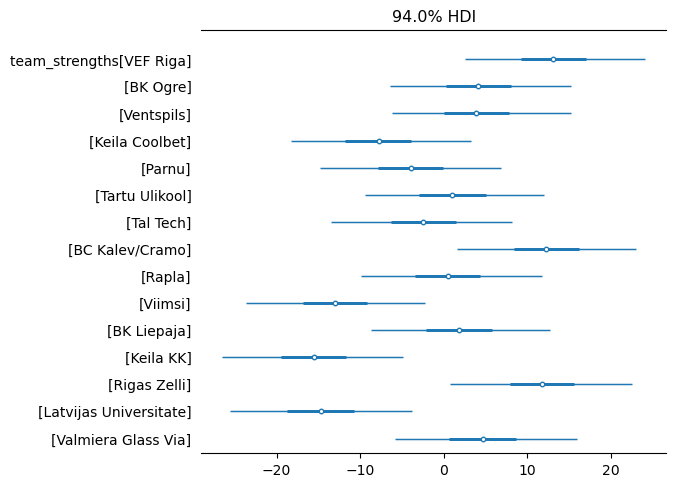

In [9]:
# Use SkewNormal for score difference

with pm.Model(coords={"teams": teams}) as model:
    # Latent strength for each team
    team_strengths = pm.Normal("team_strengths", mu=0, sigma=20, dims="teams")
    
    # Skewness parameter for SkewNormal
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    
    # Expected score difference
    mu = (team_strengths[results["home_idx"].values] 
          - team_strengths[results["away_idx"].values])
    
    # SkewNormal likelihood
    sigma = pm.HalfNormal("sigma", sigma=30)
    score_diff_obs = pm.SkewNormal("score_diff_obs", 
                                    mu=mu, sigma=sigma, alpha=alpha, 
                                    observed=results["diff"].values)
    
    # Sampling
    trace = pm.sample(accept=0.9, draws=2000) #, nuts_sampler='nutpie')
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

t_dict['skewnormal_model'] = trace

az.plot_forest(trace, var_names=["team_strengths"], combined=True, textsize=10)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [team_strengths, home_advantage, alpha, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


Output()

Sampling: [score_diff_obs]


Output()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

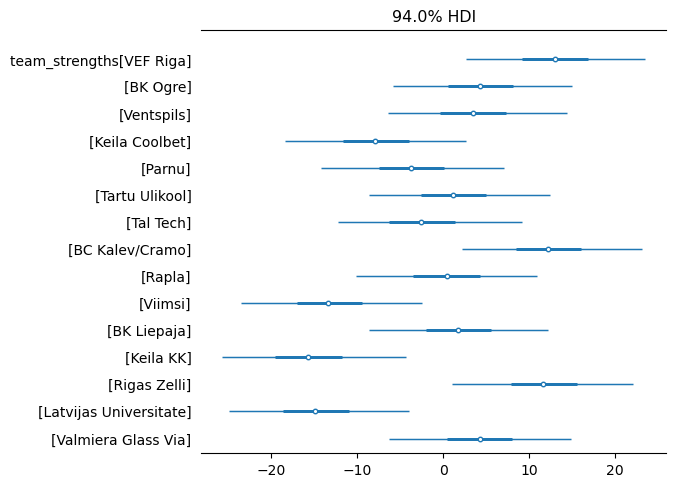

In [10]:
# Add home advantage
with pm.Model(coords={"teams": teams}) as model:
    # Latent strength for each team
    team_strengths = pm.Normal("team_strengths", mu=0, sigma=20, dims="teams")
    
    # Home advantage parameter
    home_advantage = pm.TruncatedNormal("home_advantage", mu=1, sigma=2, lower=0, dims="teams")

    # Skewness parameter for SkewNormal
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    
    # Expected score difference
    mu = (team_strengths[results["home_idx"].values] 
          - team_strengths[results["away_idx"].values] 
          + home_advantage[results['home_idx'].values])
    
    # SkewNormal likelihood
    sigma = pm.HalfNormal("sigma", sigma=30)
    score_diff_obs = pm.SkewNormal("score_diff_obs", mu=mu, sigma=sigma, alpha=alpha, observed=results["diff"].values)
    
    # Sampling
    trace = pm.sample(accept=0.9, draws=2000) #, nuts_sampler='nutpie')
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

t_dict['skewnormal_hadv_model'] = trace

az.plot_forest(trace, var_names=["team_strengths"], combined=True, textsize=10)

In [17]:
from pymc import do, observe

no_adv = np.zeros(15)

true_values = {
    "home_advantage": no_adv
}

model_simulate = do(model, true_values)

In [19]:
with model_simulate:
    idata = pm.sample(accept=0.9)
    pm.compute_log_likelihood(idata, extend_inferencedata=True)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [team_strengths, alpha, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Output()

Sampling: [score_diff_obs]


Output()

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

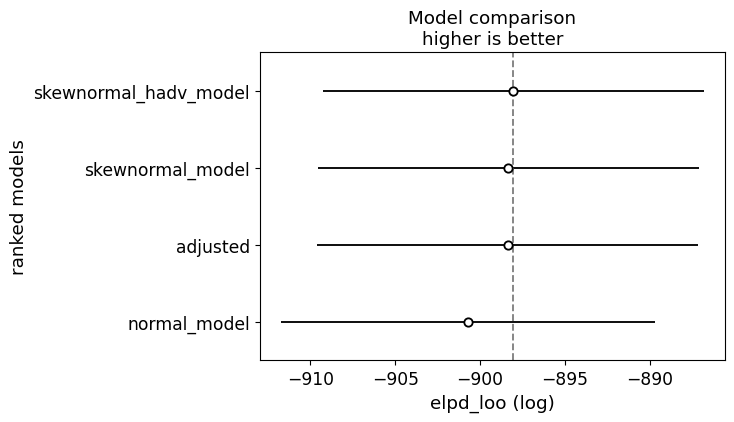

In [25]:
t_dict['adjusted'] = idata

c = az.compare(t_dict)
az.plot_compare(c)

In [ ]:
print(f"Mean home court advantage: {trace.posterior.home_advantage.mean().values:.2f}")
pm.plot_forest(trace, var_names='home_advantage', combined=True, textsize=10)

In [ ]:
# Check in: let's compare the models
c = az.compare(t_dict)
print(c)
az.plot_compare(c, textsize=10)

In [ ]:
# For this you will need to conda install pymc_extras

from pymc_extras.distributions import Skellam

# Model scores separately
with pm.Model(coords={"teams": teams}) as model:
    # Latent strength for each team
    team_strengths = pm.Normal("team_strengths", mu=60, sigma=30, dims="teams")
    
    # Home advantage parameter
    home_advantage = pm.TruncatedNormal("home_advantage", mu=1, sigma=2, lower=0)#, dims="teams")

    # Poisson distribution for home and away scores
    lambda_home = pm.math.maximum(1, team_strengths[results["home_idx"].values] + home_advantage)
    lambda_away = pm.math.maximum(1, team_strengths[results["away_idx"].values])

    # Observed scores
    home_score = pm.Poisson("home_score", lambda_home, observed=results["home_score"])
    away_score = pm.Poisson("away_score", lambda_away, observed=results["away_score"])

    # Calculate score difference and save it to posterior
    score_diff = pm.Deterministic("score_diff", home_score - away_score)
    
    trace = pm.sample() 

with model:
    # Likelihood: The score difference follows a Skellam distribution (diff of two poisson distributions)
    # We are adding it here as a pseudo-observation to get it in posterior so we can compare it with other models
    score_diff_obs = Skellam("score_diff_obs", lambda_home, lambda_away, observed=results["diff"].values)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    
t_dict['poisson_model'] = trace

az.plot_forest(trace, var_names=["team_strengths"], combined=True, textsize=10)

In [ ]:
from pymc_extras.distributions import Skellam

# Model scores separately
with pm.Model(coords={"teams": teams}) as model:
    # Latent strength for each team
    team_strengths = pm.Normal("team_strengths", mu=60, sigma=30, dims="teams")

    # Defence strength for each team, i.e. how many points they deny to the opposing team
    team_defence = pm.HalfNormal("team_defence", sigma=30, dims="teams")
    
    # Home advantage parameter
    home_advantage = pm.TruncatedNormal("home_advantage", mu=1, sigma=2, lower=0)#, dims="teams")
    
    # Poisson distribution for home and away scores
    lambda_home = pm.math.maximum(1, team_strengths[results["home_idx"].values] + home_advantage
                                    - team_defence[results["away_idx"].values])
    lambda_away = pm.math.maximum(1, team_strengths[results["away_idx"].values]
                                    - team_defence[results["home_idx"].values])

    # Observed scores
    pm.Poisson("home_score", lambda_home, observed=results["home_score"])
    pm.Poisson("away_score", lambda_away, observed=results["away_score"])
    
    trace = pm.sample() #nuts_sampler='nutpie')

with model:
    # Likelihood: The score difference follows a Skellam distribution (diff of two poisson distributions)
    # We are adding it here as a pseudo-observation to get it in posterior so we can compare it with other models
    score_diff_obs = Skellam("score_diff_obs", lambda_home, lambda_away, observed=results["diff"].values)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    
t_dict['poisson_defence_model'] = trace

az.plot_forest(trace, var_names=["team_strengths"], combined=True, textsize=10)

In [ ]:
pm.plot_trace(trace)

In [ ]:
# Multiplicative model for Poisson
with pm.Model(coords={"teams": teams}) as model:
    # Latent strength for each team
    team_offence = pm.Normal("team_offence", mu=np.log(60), sigma=5, dims="teams")
    team_defence = pm.Normal("team_defence", sigma=3, dims="teams")
    
    # Home advantage 
    home_advantage = pm.TruncatedNormal("home_advantage", mu=1, sigma=1, lower=0)#, dims="teams")

    # Another option for defense - as a multiplier for the other team's scoring rate
    lambda_home = pm.math.exp(team_offence[results["home_idx"].values] + home_advantage
                                - team_defence[results["away_idx"].values])
    lambda_away = pm.math.exp(team_offence[results["away_idx"].values] 
                                - team_defence[results["home_idx"].values])

    pm.Poisson("home_score", lambda_home, observed=results["home_score"])
    pm.Poisson("away_score", lambda_away, observed=results["away_score"])
    
    trace = pm.sample(nuts_sampler='nutpie')

with model:
    # Likelihood: The score difference follows a Skellam distribution
    score_diff_obs = Skellam("score_diff_obs", lambda_home, lambda_away, observed=results["diff"].values)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

t_dict['poisson_mult'] = trace

In [ ]:
# Model with matchup-specific effects

# Create a separate dimension name for the opponent teams
coords = {"teams": teams, "opp_teams": teams} 
with pm.Model(coords=coords) as model:
    # Latent strength for each team
    team_strengths = pm.Normal("team_strengths", mu=0, sigma=20, dims="teams")
    
    # Home advantage parameter
    home_advantage = pm.TruncatedNormal("home_advantage", mu=1, sigma=2, lower=0, dims="teams")

    # Skewness parameter for SkewNormal
    alpha = pm.Normal("alpha", mu=0, sigma=7)
    
    # Matchup effect - note the different dimension names
    matchup_effect = pm.Normal("matchup_effect", mu=0, sigma=10, dims=("teams", "opp_teams"))
    
    # Expected score difference with matchup effect
    mu = (team_strengths[results["home_idx"].values] 
          - team_strengths[results["away_idx"].values] 
          + home_advantage[results["home_idx"].values]
          + matchup_effect[results["home_idx"].values, results["away_idx"].values])
    
    # Likelihood
    sigma = pm.HalfNormal("sigma", sigma=10)
    score_diff_obs = pm.SkewNormal("score_diff_obs", mu=mu, sigma=sigma, alpha=alpha, observed=results["diff"].values)

    #w = pm.Beta("w", alpha=2, beta=2)  # Mixture weight
    #component1 = pm.SkewNormal.dist(mu=mu, sigma=sigma, alpha=alpha)
    #component2 = pm.SkewNormal.dist(mu=mu, sigma=sigma*2, alpha=alpha)  # Wider variance component
    #score_diff_obs = pm.Mixture("score_diff_obs", w=[w, 1-w], comp_dists=[component1, component2], observed=results["diff"].values)

    # Sampling
    trace = pm.sample(draws=2000, nuts_sampler='nutpie')
    pm.compute_log_likelihood(trace, extend_inferencedata=True)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

t_dict['interactions_model'] = trace

pm.plot_trace(trace)

In [ ]:
# And now ... drumroll.. the final model comparison:

comparison = az.compare(t_dict,var_name="score_diff_obs")
print(comparison)
az.plot_compare(comparison, textsize=10)